In [1]:
%matplotlib inline
import pylab
import math
import pandas as pd
import glob
from collections import defaultdict
from sourmash.lca import lca_utils
from sourmash.lca.lca_utils import LineagePair

In [2]:
#sample_id='SRR5950647'
#outdir = 'outputs.test'
sample_id='podar'
outdir = 'outputs.private'

In [3]:
# Parameters
sample_id = "p8808mo11"
render = ""
outdir = "outputs.paper"


In [4]:
from IPython.display import Markdown as md
from IPython.display import display
md(f"# genome-grist taxonomic summary for metagenome `{sample_id}`")

# genome-grist taxonomic summary for metagenome `p8808mo11`

## load gather CSV + taxonomy

In [5]:
# load gather CSV
tax_df = pd.read_csv(f'../../{outdir}/gather/{sample_id}.gather.with-lineages.csv')

In [6]:
tax_ranks = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# "fix" lineage column,
def split_lineages(x):
#    print((x, type(x)))
    if isinstance(x, float) and math.isnan(x):
        return ()

    ret = []
    for (rank, name) in zip(tax_ranks, x.split(';')):
        ret.append(LineagePair(rank, name))
    return tuple(ret)
    
tax_df['lineage'] = tax_df['lineage'].apply(split_lineages)

# and break it up into tuples

def grab_tax(x, idx):
    if x:
        return x[idx].name
    return ''

for idx, rank in enumerate(tax_ranks):
    tax_df[rank] = tax_df['lineage'].apply(grab_tax, args=(idx,))

In [7]:
# create function that aggregates various pieces of information by rank & builds a new df
def aggregate_by_rank(df, rank):
    # first, build all the counts
    unique_intersect_by_rank = defaultdict(int)
    f_intersect_by_rank = defaultdict(int)
    best_hashes_by_rank = {}

    def sum_unique(row):
        lin = row.lineage
        if pd.isnull(lin):
            lin = []
        unique_hashes = row.unique_intersect_bp
        f_hashes = row.f_unique_to_query

        for rank in ('superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'):
            poplin = lca_utils.pop_to_rank(lin, rank)
            unique_intersect_by_rank[poplin] += unique_hashes
            f_intersect_by_rank[poplin] += f_hashes
            
            best_hashes = best_hashes_by_rank.get(poplin, 0)
            if best_hashes < unique_hashes:
                best_hashes_by_rank[poplin] = unique_hashes

    df.apply(sum_unique, axis=1)

    # now do the sorting etc.
    rank_counts = []
    for lin, bp in sorted(unique_intersect_by_rank.items(), key=lambda x: -x[1]):
        if lin and lin[-1].rank == rank:
            
            f_unique = f_intersect_by_rank[lin]
            if rank == 'species':
                name = lin[-1].name
                name = f'{name} ({lin[0].name})'
            elif rank == 'genus':
                name = lin[-1].name
                name = f'{name}'
            else:
                name = lca_utils.display_lineage(lin)

            rank_counts.append(dict(name=name, hashes=bp, f_unique=f_unique,
                                    best_hashes=best_hashes_by_rank[lin],
                                    lineage=lin))
            
    name = "unclassified"
    hashes = 0 # CTB fixme
    f_unique = 1 - sum(v for (k, v) in f_intersect_by_rank.items() if k and k[-1].rank == rank )
    best_hashes = 0 # CTB
    lineage = ()
    rank_counts.append(dict(name=name, hashes=bp, f_unique=f_unique,
                            best_hashes=best_hashes_by_rank[lin],
                            lineage=lin))    

    return pd.DataFrame(rank_counts)

species_df = aggregate_by_rank(tax_df, 'species')
genus_df = aggregate_by_rank(tax_df, 'genus')
family_df = aggregate_by_rank(tax_df, 'family')
order_df = aggregate_by_rank(tax_df, 'order')
class_df = aggregate_by_rank(tax_df, 'class')
phylum_df = aggregate_by_rank(tax_df, 'phylum')

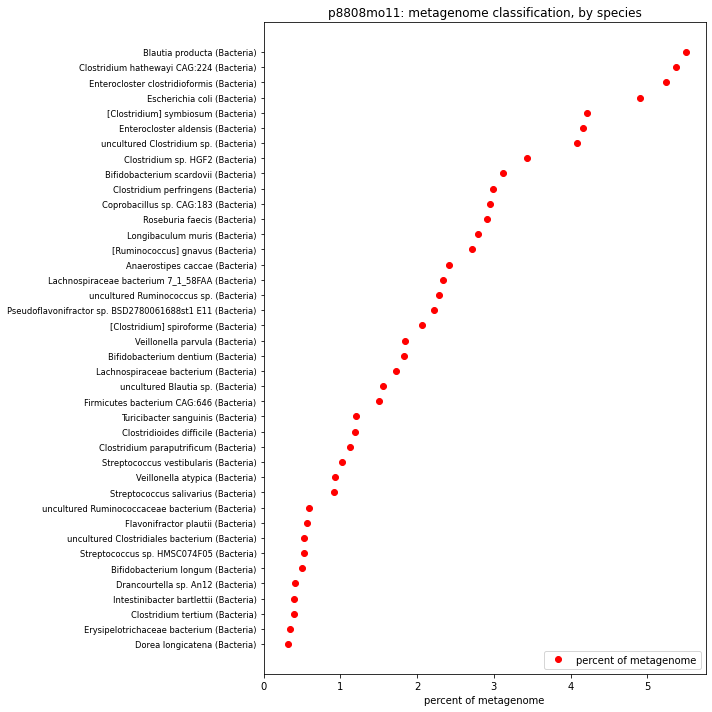

In [8]:
rank = 'species'
plot_df = species_df

pylab.figure(num=None, figsize=(10, 10))

plot_df = plot_df[:40]
#pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.f_unique * 100, plot_df.iloc[::-1].index, 'ro', label='percent of metagenome')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('percent of metagenome')
pylab.axis(xmin=0)
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: metagenome classification, by {rank}')
pylab.tight_layout()

#figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
#print(f'saving to {figname}')
#pylab.savefig(figname)

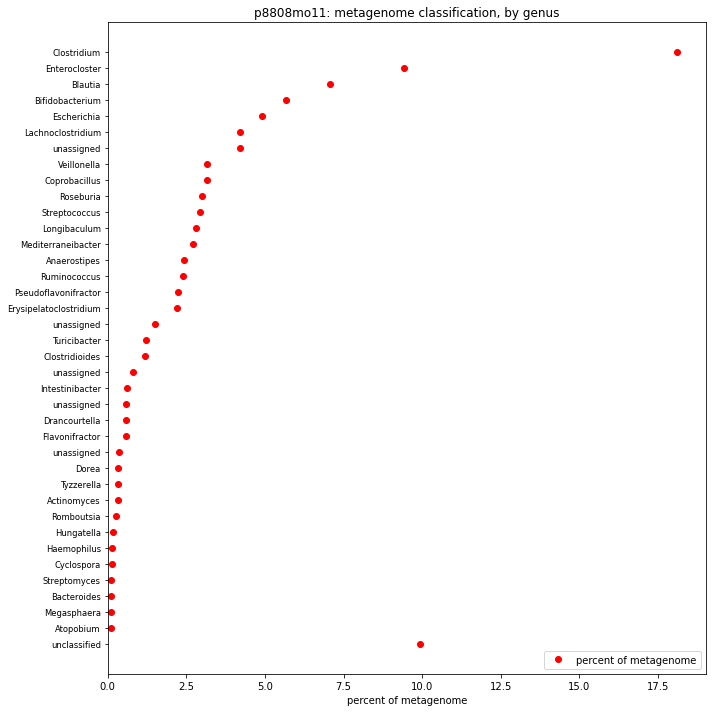

In [9]:
rank = 'genus'
plot_df = genus_df

pylab.figure(num=None, figsize=(10, 10))

plot_df = plot_df[:40]
#pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.f_unique * 100, plot_df.iloc[::-1].index, 'ro', label='percent of metagenome')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('percent of metagenome')
pylab.axis(xmin=0)
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: metagenome classification, by {rank}')
pylab.tight_layout()

#figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
#print(f'saving to {figname}')
#pylab.savefig(figname)

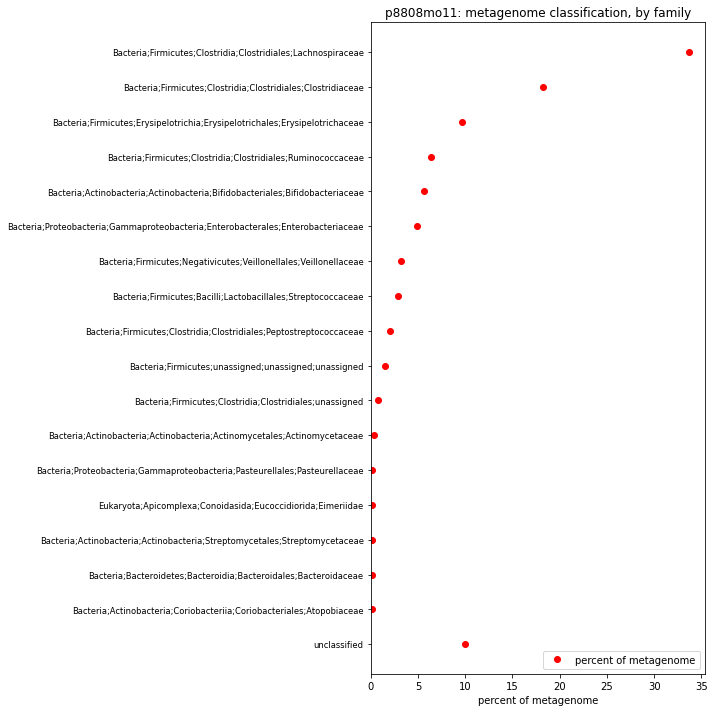

In [10]:
rank = 'family'
plot_df = family_df

pylab.figure(num=None, figsize=(10, 10))

plot_df = plot_df[:40]
#pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.f_unique * 100, plot_df.iloc[::-1].index, 'ro', label='percent of metagenome')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('percent of metagenome')
pylab.axis(xmin=0)
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: metagenome classification, by {rank}')
pylab.tight_layout()

#figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
#print(f'saving to {figname}')
#pylab.savefig(figname)

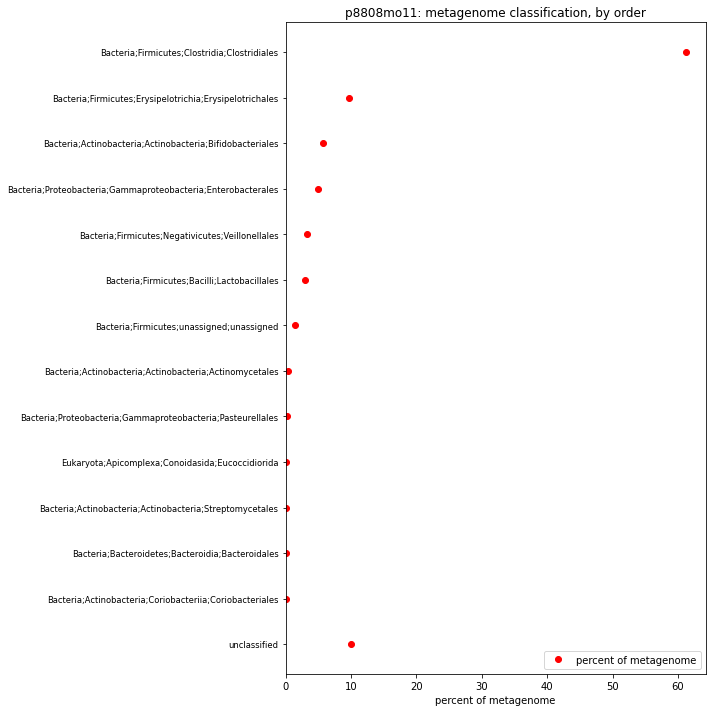

In [11]:
rank = 'order'
plot_df = order_df

pylab.figure(num=None, figsize=(10, 10))

plot_df = plot_df[:40]
#pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.f_unique * 100, plot_df.iloc[::-1].index, 'ro', label='percent of metagenome')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('percent of metagenome')
pylab.axis(xmin=0)
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: metagenome classification, by {rank}')
pylab.tight_layout()

#figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
#print(f'saving to {figname}')
#pylab.savefig(figname)

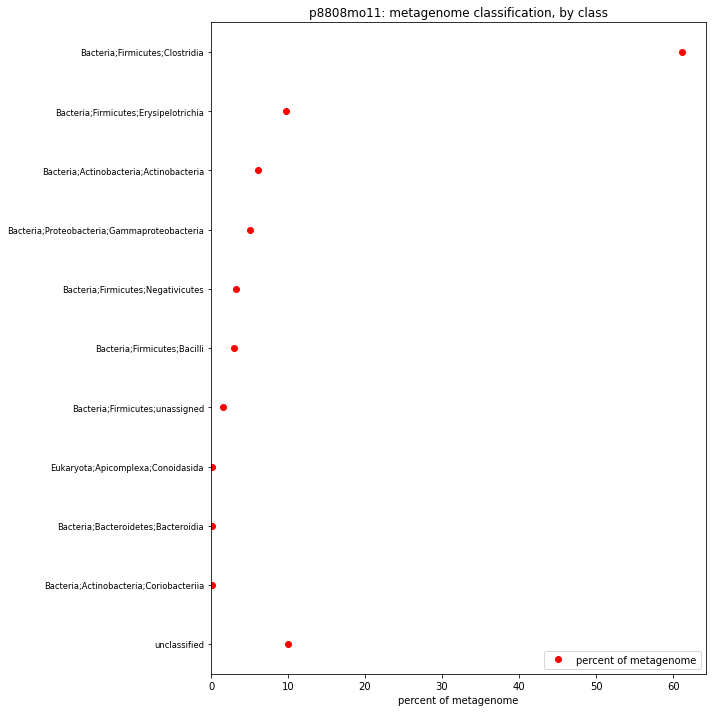

In [12]:
rank = 'class'
plot_df = class_df

pylab.figure(num=None, figsize=(10, 10))

plot_df = plot_df[:40]
#pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.f_unique * 100, plot_df.iloc[::-1].index, 'ro', label='percent of metagenome')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('percent of metagenome')
pylab.axis(xmin=0)
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: metagenome classification, by {rank}')
pylab.tight_layout()

#figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
#print(f'saving to {figname}')
#pylab.savefig(figname)

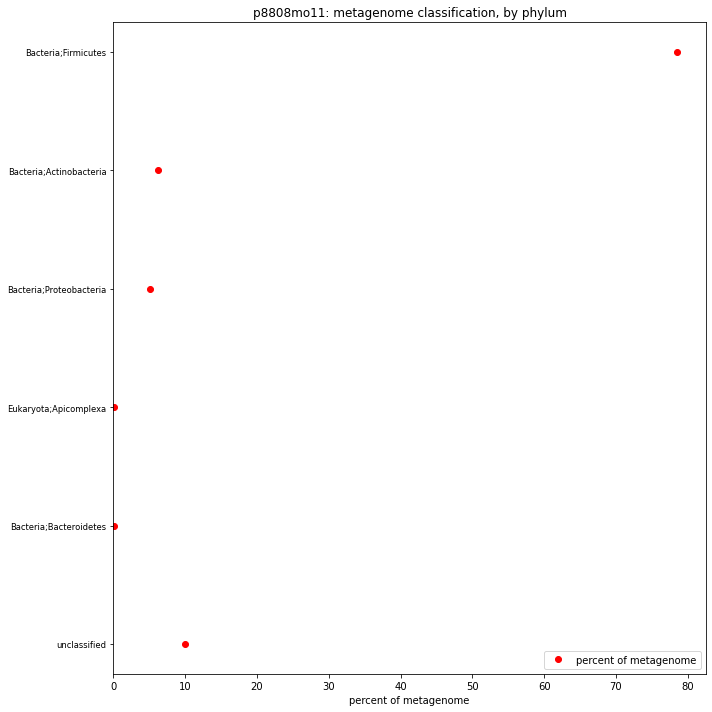

In [13]:
rank = 'phylum'
plot_df = phylum_df

pylab.figure(num=None, figsize=(10, 10))

plot_df = plot_df[:40]
#pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.f_unique * 100, plot_df.iloc[::-1].index, 'ro', label='percent of metagenome')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('percent of metagenome')
pylab.axis(xmin=0)
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: metagenome classification, by {rank}')
pylab.tight_layout()

#figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
#print(f'saving to {figname}')
#pylab.savefig(figname)